In [1]:
import psycopg2

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Subset, DataLoader

from Dataset.Embedding_Dataset import Embedding_Dataset
from Model.Embedding import Embedding

from Dataset.LSTM_Dataset import LSTM_Dataset
from Model.LSTM import LSTM
from Model.NLinear import NLinear
from Model.Transformer import Transformer

from Dataset.Attention_Dataset import Attention_Dataset
from Model.Attention import LSTMSeq2Seq


SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cpu') # CPU
# DEVICE = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu') # MAC
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # WINDOW

## Data

In [2]:
connection_info = "host=localhost dbname=postgres user=postgres password=hd219833 port=5432"
conn = psycopg2.connect(connection_info)
table_1_query = '''
    SELECT * FROM building
    '''
table_2_query = '''
    SELECT * FROM economy
    '''
table_3_query = '''
    SELECT * FROM building_price
    '''
table_1 = pd.read_sql(table_1_query,conn) 
table_2 = pd.read_sql(table_2_query,conn)
table_3 = pd.read_sql(table_3_query,conn) 

# table_1 = pd.read_csv('../데이터/Table/table_1.csv') 
# table_2 = pd.read_csv('../데이터/Table/table_2.csv') 
# table_3 = pd.read_csv('../데이터/Table/table_3.csv') 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


## RMSE

In [3]:
class RMSE(nn.Module):
    def __init__(self):
        super(RMSE,self).__init__()
        self.mse = nn.MSELoss()
        self.eps = 1e-7

    def forward(self, y, y_hat):
        return torch.sqrt(self.mse(y, y_hat) + self.eps)

## Plot Losses

In [4]:
def plot_train_val_losses(train_losses, val_losses):
    print(f'Min Validation Loss: {min(val_losses)}')
    plt.plot(train_losses[1:], label='Training Loss')
    plt.plot(val_losses[1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

## Early Stop

In [5]:
# val loss가 연속적으로 오를 때
def early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases):
    if len(val_losses) > 1 and val_losses[-1] > val_losses[-2]:
        consecutive_val_loss_increases += 1
        if consecutive_val_loss_increases >= max_consecutive_val_loss_increases:
            return True, consecutive_val_loss_increases
        else:
            return False, consecutive_val_loss_increases
    else:
        consecutive_val_loss_increases = 0
        return False, consecutive_val_loss_increases

# val loss가 최저 loss보다 연속적으로 클 때
def early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases):
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        consecutive_val_loss_increases = 0
    else:
        consecutive_val_loss_increases += 1
    if consecutive_val_loss_increases >= max_consecutive_val_loss_increases:
        return True, best_val_loss, consecutive_val_loss_increases
    else:
        return False, best_val_loss, consecutive_val_loss_increases

## Hyperparameters

In [6]:
train_ratio = 0.8

embedding_lr = 0.00001
embedding_weight_decay = 0
embedding_batch = 128
embedding_epochs = 150
encoder_dim_1 = 128
encoder_dim_2 = 256
encoder_dim_3 = 512
embedding_dim = 1024
decoder_dim_1 = 512
decoder_dim_2 = 256
decoder_dim_3 = 128

lstm_lr = 0.0001
lstm_weight_decay = 0
lstm_batch = 128
lstm_epochs = 150
lstm_hidden_dim = 256
lstm_window_size = 10

nlinear_lr = 0.0001
nlinear_weight_decay = 0
nlinear_batch = 128
nlinear_epochs = 150
nlinear_window_size = 10

attention_lr = 0.0001
attention_weight_decay = 0
attention_batch = 1
attention_epochs = 150
attention_hidden_dim = 256
attention_window_size = 10

transformer_lr = 0.0001
transformer_weight_decay = 0
transformer_batch = 1
transformer_epochs = 150
transformer_window_size = 10

## Embedding

In [37]:
dataset = Embedding_Dataset(table_1, table_2, table_3)
dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)

In [38]:
model = Embedding(encoder_dim_1, encoder_dim_2, encoder_dim_3, embedding_dim, decoder_dim_1, decoder_dim_2, decoder_dim_3).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=embedding_lr, weight_decay=embedding_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(embedding_epochs):
    model.train()
    total_train_loss = 0
    for data in train_dataloader:
        input = data[0].to(DEVICE)
        target = data[1].to(DEVICE)
        output = model(input).to(DEVICE)

        train_loss = criterion(output, target)
        total_train_loss += train_loss.item()

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            input = data[0].to(DEVICE)
            target = data[1].to(DEVICE)
            output = model(input).to(DEVICE)

            val_loss = criterion(output, target)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    # early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/embedding_tr_{train_ratio}_lr_{embedding_lr}_wd_{embedding_weight_decay}_batch_{embedding_batch}_epochs_{epoch+1}_e1_{encoder_dim_1}_e2_{encoder_dim_1}_e3_{encoder_dim_3}_emb_{embedding_dim}_d1{decoder_dim_1}_d2_{decoder_dim_2}_d3_{decoder_dim_3}.pth')
        break

    print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/150], Train Loss: 6.5733, Val Loss: 6.5547
Epoch [2/150], Train Loss: 6.1573, Val Loss: 6.1832
Epoch [3/150], Train Loss: 5.8074, Val Loss: 5.8475
Epoch [4/150], Train Loss: 5.5186, Val Loss: 5.6872
Epoch [5/150], Train Loss: 5.2767, Val Loss: 5.6049
Epoch [6/150], Train Loss: 5.0581, Val Loss: 5.5336
Epoch [7/150], Train Loss: 4.8496, Val Loss: 5.4536
Epoch [8/150], Train Loss: 4.6445, Val Loss: 5.3707
Epoch [9/150], Train Loss: 4.4425, Val Loss: 5.2748
Epoch [10/150], Train Loss: 4.2416, Val Loss: 5.1627
Epoch [11/150], Train Loss: 4.0387, Val Loss: 5.0454
Epoch [12/150], Train Loss: 3.8370, Val Loss: 4.9116
Epoch [13/150], Train Loss: 3.6349, Val Loss: 4.7740
Epoch [14/150], Train Loss: 3.4363, Val Loss: 4.6406
Epoch [15/150], Train Loss: 3.2418, Val Loss: 4.5186
Epoch [16/150], Train Loss: 3.0546, Val Loss: 4.4094
Epoch [17/150], Train Loss: 2.8873, Val Loss: 4.3045
Epoch [18/150], Train Loss: 2.7439, Val Loss: 4.2002
Epoch [19/150], Train Loss: 2.6217, Val Loss: 4.1211
Ep

Min Validation Loss: 3.14601547901447


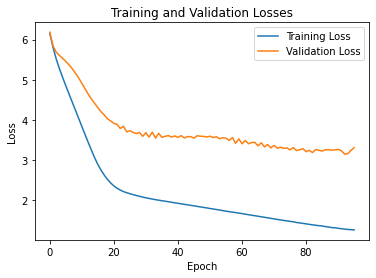

In [39]:
plot_train_val_losses(train_losses, val_losses)

## LSTM

In [11]:
model = torch.load('../데이터/Checkpoint/embedding_tr_0.8_lr_1e-05_wd_0_batch_128_epochs_97_e1_128_e2_128_e3_512_emb_1024_d1512_d2_256_d3_128.pth')
dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, lstm_window_size)

dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=embedding_batch, shuffle=False, drop_last=True)

In [16]:
model = LSTM(embedding_dim, lstm_hidden_dim)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=lstm_lr, weight_decay=lstm_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(lstm_epochs):
    model.train()
    total_train_loss = 0
    for data in train_dataloader:
        src = data[0]
        trg = data[1]

        if trg.sum() != 0: 
            output, _, _ = model(src)
            
            train_loss = criterion(output, trg)
            total_train_loss += train_loss.item()

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0]
            trg = data[1]

            if trg.sum() != 0:
                output, _, _ = model(src)

                val_loss = criterion(output, trg)
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/lstm_tr_{train_ratio}_lr_{lstm_lr}_wd_{lstm_weight_decay}_batch_{lstm_batch}_epochs_{epoch+1}_hdim_{lstm_hidden_dim}_ws_{lstm_window_size}.pth')
        break

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/150], Train Loss: 0.0579, Val Loss: 0.0221
Epoch [2/150], Train Loss: 0.0162, Val Loss: 0.0095
Epoch [3/150], Train Loss: 0.0064, Val Loss: 0.0048
Epoch [4/150], Train Loss: 0.0037, Val Loss: 0.0074
Epoch [5/150], Train Loss: 0.0027, Val Loss: 0.0030
Epoch [6/150], Train Loss: 0.0019, Val Loss: 0.0020
Epoch [7/150], Train Loss: 0.0015, Val Loss: 0.0021
Epoch [8/150], Train Loss: 0.0011, Val Loss: 0.0015
Epoch [9/150], Train Loss: 0.0009, Val Loss: 0.0011
Epoch [10/150], Train Loss: 0.0008, Val Loss: 0.0025
Epoch [11/150], Train Loss: 0.0007, Val Loss: 0.0023
Epoch [12/150], Train Loss: 0.0007, Val Loss: 0.0016 
Early Stop Triggered!


Min Validation Loss: 0.0010975338108145701


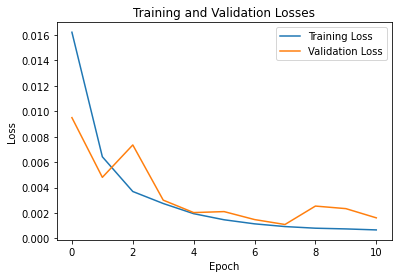

In [17]:
plot_train_val_losses(train_losses, val_losses)

## NLinear

In [24]:
model = torch.load('../데이터/Checkpoint/embedding_tr_0.8_lr_1e-05_wd_0_batch_128_epochs_97_e1_128_e2_128_e3_512_emb_1024_d1512_d2_256_d3_128.pth')
dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, nlinear_window_size)

dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=nlinear_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=nlinear_batch, shuffle=False, drop_last=True)

In [25]:
model = NLinear(embedding_dim, nlinear_window_size).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=nlinear_lr, weight_decay=nlinear_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(nlinear_epochs):
    model.train()
    total_train_loss = 0
    for data in train_dataloader:
        src = data[0].to(DEVICE)
        trg = data[1].to(DEVICE)

        if trg.sum() != 0:
            output = model(src)

            train_loss = criterion(output, trg)
            total_train_loss += train_loss.item()
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0].to(DEVICE)
            trg = data[1].to(DEVICE)

            if trg.sum() != 0:
                output = model(src)

                val_loss = criterion(output, trg)
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/nlinear_tr_{train_ratio}_lr_{nlinear_lr}_wd_{nlinear_weight_decay}_batch_{nlinear_batch}_epochs_{epoch+1}_emb_{embedding_dim}_ws_{nlinear_window_size}.pth')
        break

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [1/150], Train Loss: 0.3216, Val Loss: 0.1944
Epoch [2/150], Train Loss: 0.1736, Val Loss: 0.1169
Epoch [3/150], Train Loss: 0.1104, Val Loss: 0.0789


KeyboardInterrupt: 

In [ ]:
plot_train_val_losses(train_losses, val_losses)

## Attention

In [9]:
model = torch.load('../데이터/Checkpoint/embedding_tr_0.8_lr_1e-05_wd_0_batch_128_epochs_97_e1_128_e2_128_e3_512_emb_1024_d1512_d2_256_d3_128.pth')
dataset = Attention_Dataset(model, table_1, table_2, table_3, embedding_dim, attention_window_size)

dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=attention_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=attention_batch, shuffle=False, drop_last=True)

In [20]:
model = LSTMSeq2Seq(embedding_dim, attention_hidden_dim, 1).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=attention_lr, weight_decay=attention_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(attention_epochs):
    model.train()
    total_train_loss = 0
    for data in train_dataloader:
        src = data[0][0].to(DEVICE)
        max_len = data[1][0].to(DEVICE)
        anw = data[2][0].to(DEVICE)
        trg = data[3][0].to(DEVICE)
        
        if len(anw)==0:
            continue
    
        # dong_loss = 0

        for index in anw:
            output = model(src, index, max_len)

            train_loss = criterion(output, trg[index])
            total_train_loss += train_loss.item()
            # dong_loss += loss.item()
            
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

        # optimizer.zero_grad()
        # # dong_loss /= len(anw)
        # dong_loss = torch.tensor(dong_loss, requires_grad=True).to(DEVICE)
        # dong_loss.backward()
        # optimizer.step()
            
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0][0].to(DEVICE)
            max_len = data[1][0].to(DEVICE)
            anw = data[2][0].to(DEVICE)
            trg = data[3][0].to(DEVICE)

            if len(anw)==0:
                continue

            for index in anw:
                output = model(src, index, max_len)

                val_loss = criterion(output, trg[index])
                total_val_loss += val_loss.item()
                
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
            
    # early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/attention_tr_{train_ratio}_lr_{attention_lr}_wd_{attention_weight_decay}_batch_{attention_batch}_epochs_{epoch+1}_hdim_{attention_hidden_dim}_ws_{attention_window_size}.pth')
        break

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

## Transformer

In [7]:
model = torch.load('../데이터/Checkpoint/embedding_tr_0.8_lr_1e-05_wd_0_batch_128_epochs_97_e1_128_e2_128_e3_512_emb_1024_d1512_d2_256_d3_128.pth')
dataset = LSTM_Dataset(model, table_1, table_2, table_3, embedding_dim, transformer_window_size)

dataset_length = len(dataset)
split_point = int(train_ratio * len(dataset))
train_indices = range(0, split_point)
val_indices = range(split_point, dataset_length)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

train_dataloader = DataLoader(train_dataset, batch_size=transformer_batch, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=transformer_batch, shuffle=False, drop_last=True)

In [8]:
model = Transformer(embedding_dim, transformer_window_size, 1, 2, 2).to(DEVICE)
criterion = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=transformer_lr, weight_decay=transformer_weight_decay)

train_losses = []
val_losses = []
best_val_loss = float('inf')
consecutive_val_loss_increases = 0
max_consecutive_val_loss_increases = 3

for epoch in range(transformer_epochs):
    model.train()
    total_train_loss = 0
    for i, data in enumerate(train_dataloader):
        src = data[0].to(DEVICE)
        trg = data[1].to(DEVICE)

        if (trg[0] != 0):
            src_mask = model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
            output = model(src, src_mask)

            train_loss = criterion(output[0], trg[0])
            total_train_loss += train_loss.item()

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()
            
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for data in val_dataloader:
            src = data[0].to(DEVICE)
            trg = data[1].to(DEVICE)

            if (trg[0] != 0):
                src_mask = model.generate_square_subsequent_mask(src.shape[1]).to(src.device)
                output = model(src, src_mask)

                val_loss = criterion(output[0], trg[0])
                total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # early_stop, consecutive_val_loss_increases = early_stop_1(val_losses, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    early_stop, best_val_loss, consecutive_val_loss_increases = early_stop_2(avg_val_loss, best_val_loss, consecutive_val_loss_increases, max_consecutive_val_loss_increases)
    if early_stop:
        print(f'Epoch [{epoch+1}/{embedding_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f} \nEarly Stop Triggered!')
        torch.save(model, f'../데이터/Checkpoint/transformer_tr_{train_ratio}_lr_{transformer_lr}_wd_{transformer_weight_decay}_batch_{transformer_batch}_epochs_{epoch+1}_ws_{transformer_window_size}.pth')
        break

    print(f'Epoch [{epoch+1}/{lstm_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


KeyboardInterrupt: 